# Predict and rank NPLs
In this notebook, I apply the predictive models developed in the *modeling_and_performance_part2.ipynb* over the most recent NPLs (09-2017) in order to predict the **probability of recovery** and the **expected recovery rate** in the following 12 months. The NPLs are then ranked by those two predicted values.

In order to facilitate the work of portfolio managers, the probability of recovery is used to define a **recovery class**, i.e. group of NPLs within a given range of probability. The following class are defined:

* Class A: very likely to recover
    * Probability of recovery [0.75, 1.00];
* Class B: likely to recover
    * Probability of recovery [0.50, 0.75];
* Class C: unlikely to recover:
    * Probability of recovery [0.25, 0.50];
* Class D: very unlikely to recover
    * Probability of recovery [0.00, 0.25];

The final results will then be summarised in term of recovery class, providing the total recovery rate and the total recovered amount expected in the 12 months following the 09-2017.

The ranked list of NPL will be make aviable on a csv file.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from classifier_utils import *

# Load pre-processed dataset

In [2]:
df = pd.read_csv('sample_for_model.csv'
                  , parse_dates=['NUM_ANNO', 'NUM_YYYYMM', 'NUM_DATA_SOFFERENZA']
                  , dtype={'HAS_RECOVERED_12M': bool, 'HAS_RECOVERED_12M_AHEAD': bool})

In [3]:
df.shape

(484743, 46)

# Feature selection

In [4]:
numerical_cols=[
    'IMP_GBV',
    'IMP_CUSUM_INCASSI',
    'MAX_IMP_GBV',
    'RECOVERY_RATE_TOTAL',
    'NUM_MONTHS_SOFFERENZA',
    'Contabile linea interessi di mora',
    'Credito vantato',
    'NUM_ENTI_SEGNALANTI',
    'NUM_COMPONENTI_COINTESTAZIONE',
    'NUM_ID_RAPPORTO',
    'NUM_ID_GARANTE',
    'IMP_INCASSI_ROLLING_12M'
    ,'IMP_GAR',
]
categorical_cols=[]

target_classifier = 'HAS_RECOVERED_12M_AHEAD'
target_regressor = 'RECOVERY_RATE_12M_AHEAD'

# Encode categorical features

In [5]:
# This is not necessary with this set of feature, but 
# it mightr be required in future release.
prefix = ['CAT_' + s for s in categorical_cols]

df_encoded=pd.get_dummies(df, columns=categorical_cols, dummy_na=True, prefix=prefix)

encoded_categorical_cols = list(filter(lambda x: 'CAT_' in x, df_encoded.columns))

In [6]:
df_encoded.shape

(484743, 46)

# Prediction sample

In [7]:
sample_prediction=df_encoded.loc[df_encoded['NUM_YYYYMM'] == df_encoded['NUM_YYYYMM'].max()]
sample_prediction.shape

(18786, 46)

# Load models
Load model from the external joblib files and prepare the function to apply them to the different datapoints depending from the customer type.

In [8]:
import joblib

models_dict = {}

cols = numerical_cols + encoded_categorical_cols

models_dict['F'] = {
    'features' : cols,
    'classifier' : joblib.load('classifier_random_forest_pf_20191105.joblib'),
    'regressor' : joblib.load('regressor_random_forest_pf_20191105.joblib')
}

models_dict['G'] = {
    'features' : list(filter(lambda s: s!= 'IMP_GAR', cols)),
    'classifier' : joblib.load('classifier_random_forest_pg_20191105.joblib'),
    'regressor' : joblib.load('regressor_random_forest_pg_20191105.joblib')
}

models_dict['C'] = {
    'features' : list(filter(lambda s: s!= 'IMP_GAR', cols)),
    'classifier' : joblib.load('classifier_random_forest_c_20191105.joblib'),
    'regressor' : joblib.load('regressor_random_forest_c_20191105.joblib')
}


In [9]:
def apply_model(name, df, models_dict=models_dict):
    
    prob = models_dict[name]['classifier'].predict_proba(df[models_dict[name]['features']])
    pred = models_dict[name]['regressor'].predict(df[models_dict[name]['features']])

    return pd.DataFrame({
        'ID_CUSTOMER' : df['ID_CUSTOMER'].values,
        'IMP_GBV' : df['IMP_GBV'].values,
        'PRED_PROB_RECOVERY_12M_AHEAD' : prob[:,1], # I am only interested in the probability for class 1, i.e. target variable == True    
        'PRED_RECOVERY_RATE_12M_AHEAD' : pred
    })

# Apply model 

In [10]:
model_prediction=sample_prediction.groupby('COD_TIPO_NDG').apply(
    lambda x: apply_model(x.name, x)
).reset_index(-2)

In [11]:
model_prediction.head()

,COD_TIPO_NDG,ID_CUSTOMER,IMP_GBV,PRED_PROB_RECOVERY_12M_AHEAD,PRED_RECOVERY_RATE_12M_AHEAD
0,C,7,63.13,0.577436,0.504080
1,C,11,1930.97,0.856599,0.415380
2,C,59,76.10,0.058328,0.003402
3,C,78,759.09,0.037779,0.032719
4,C,91,105.81,0.228014,0.159764


In [12]:
# Compute the predicted recovery amount
model_prediction['PRED_INCASSI_12M_AHEAD'] = model_prediction['PRED_RECOVERY_RATE_12M_AHEAD'] * model_prediction['IMP_GBV']

# Bucket the probability into 4 different class
model_prediction['PRED_RECOVERY_CLASS'] = pd.cut(
    model_prediction['PRED_PROB_RECOVERY_12M_AHEAD'], 
    bins=[0, 0.25,0.5,0.75,1.], 
    labels=['D', 'C', 'B', 'A'])

In [13]:
model_prediction.head()

,COD_TIPO_NDG,ID_CUSTOMER,IMP_GBV,PRED_PROB_RECOVERY_12M_AHEAD,PRED_RECOVERY_RATE_12M_AHEAD,PRED_INCASSI_12M_AHEAD,PRED_RECOVERY_CLASS
0,C,7,63.13,0.577436,0.504080,31.822598,B
1,C,11,1930.97,0.856599,0.415380,802.085882,A
2,C,59,76.10,0.058328,0.003402,0.258873,D
3,C,78,759.09,0.037779,0.032719,24.836991,D
4,C,91,105.81,0.228014,0.159764,16.904667,D


# Sorting NPL by the probability of recovery and by the recovery rate

In [14]:
npl_sorted = model_prediction.sort_values(by=['PRED_RECOVERY_CLASS', 'PRED_RECOVERY_RATE_12M_AHEAD'], ascending=False)
display(npl_sorted)

,COD_TIPO_NDG,ID_CUSTOMER,IMP_GBV,PRED_PROB_RECOVERY_12M_AHEAD,PRED_RECOVERY_RATE_12M_AHEAD,PRED_INCASSI_12M_AHEAD,PRED_RECOVERY_CLASS
4990,C,27024,517.45,0.830976,7.616390e-01,394.110118,A
3075,F,17405,3032.61,0.896712,6.793517e-01,2060.208666,A
138,G,434,283.18,0.883208,6.741502e-01,190.905846,A
385,C,6735,467.58,0.948984,6.318838e-01,295.456212,A
373,C,6706,500.14,0.935252,6.190703e-01,309.621822,A
5753,F,27177,8210.79,0.888776,6.135325e-01,5037.586623,A
630,F,6118,812.93,0.827547,5.980373e-01,486.162472,A
1453,G,7161,1596.68,0.797899,5.955661e-01,950.928505,A
3314,F,18357,771.51,0.904660,5.904105e-01,455.507616,A
5645,F,26852,1395.38,0.788217,5.773679e-01,805.647588,A


In [15]:
npl_sorted.to_csv('npl_sorted.csv', index=False)

* NPLs are sorted by the probability of recovery and by the recovery rate expected in the next 12 months.
* The value of the probability is used to define a predicted *recovery class*: A, B, C, D
* The predicted values are exported to a csv files together additional informatio that might be usefull.

# Summary 

In [35]:
summary = model_prediction.groupby('PRED_RECOVERY_CLASS').agg({
    'PRED_RECOVERY_CLASS' : 'size',
    'IMP_GBV' : 'sum',
    'PRED_INCASSI_12M_AHEAD' : 'sum'
})

summary.rename(columns={
    'PRED_RECOVERY_CLASS': 'NUM_CUSTOMERS',
    'IMP_GBV' : 'TOTAL_IMP_GBV',
    'PRED_INCASSI_12M_AHEAD' : 'PRED_TOTAL_INCASSI'    
}, inplace=True)

summary['FRAC_CUSTOMERS']= summary['NUM_CUSTOMERS']/summary['NUM_CUSTOMERS'].sum()

summary['PRED_TOTAL_RECOVERY_RATE']=summary['PRED_TOTAL_INCASSI'] / summary['TOTAL_IMP_GBV']

cols = ['NUM_CUSTOMERS', 'FRAC_CUSTOMERS', 'TOTAL_IMP_GBV', 'PRED_TOTAL_INCASSI', 'PRED_TOTAL_RECOVERY_RATE']

display(summary[cols])

,NUM_CUSTOMERS,FRAC_CUSTOMERS,TOTAL_IMP_GBV,PRED_TOTAL_INCASSI,PRED_TOTAL_RECOVERY_RATE
PRED_RECOVERY_CLASS,,,,,
D,12153,0.646987,71896323.30,2.501808e+06,0.034797
C,3847,0.204802,25850577.60,1.953762e+06,0.075579
B,1357,0.072242,8580449.95,8.459877e+05,0.098595
A,1427,0.075969,7516635.67,7.698283e+05,0.102417


The table above summarise the level of recovery expected at 09-2017 from different recovery class. 

Class A contains the NPLs which are more likely to recover (Prob > 75%). A total of 1427 NPLs (7.6%) are in this class. The total debt corresponding to this class is 7.5M€, the predicted recovery rate is 10% which correspond to recover about 0.8M€. 

Class B conatins the NPLs which are likely to recover (Prob within 50% and 75%). A total of 135727 NPLs (7.2%) are in this class. The total debt corresponding to this class is 8.6M€, the predicted recovery rate is 10% which correspond to recover about 0.8M€. 

Class C contains the NPLs which are not likely tro recover (Prob within 25% and 50%). A total of 3847 NPLs (20%) are in this class. The total debt corresponding to this class is 25.8M€, the predicted recovery rate is about 7.5% which correspond to recover about 1.9M€. 

Finally class D contains the NPLs which are very unlikely to recover (Prob < 25%). A total of 12153 NPLs (64%) are in this class. The total debt corresponding to this class is about 72M€, the predicted recovery rate is 3.5% which correspond to recover about 2.5M€.

Given the NPL sample as of 09-2017, the expected recovery rate that is between 1.6M€ (considering only A and B classes) and 6M€ (considering also C and D classes).

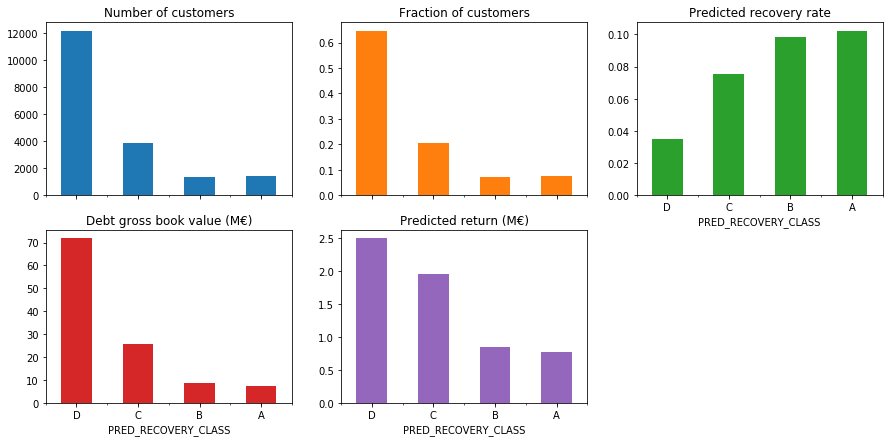

In [47]:
titles=['Number of customers', 
        'Fraction of customers', 
        'Predicted recovery rate',
        'Debt gross book value (M€)', 
        'Predicted return (M€)']

tmp=summary.copy()

cols=['NUM_CUSTOMERS', 'FRAC_CUSTOMERS', 'PRED_TOTAL_RECOVERY_RATE', 'TOTAL_IMP_GBV', 'PRED_TOTAL_INCASSI', ]

tmp[['TOTAL_IMP_GBV', 'PRED_TOTAL_INCASSI']] = tmp[['TOTAL_IMP_GBV', 'PRED_TOTAL_INCASSI']] / 1e6

axs=tmp[cols].plot.bar(subplots=True, rot=0, figsize=(15,7),layout=(2,3), legend=False, title=titles)

plt.show()